# Generate decision tree and visualize it graphically

## Reload on each run, since we’re editing the decision_tree library

In [1]:
%load_ext autoreload
%autoreload 2

## Import libraries

In [2]:
from decision_tree import *
from graphviz import Digraph
from IPython.display import SVG
from IPython.core.display import display

## Sample data

In [3]:
# sample data with a bit of repetition
witnessData = {'wit1': ['a', 'b', 'c', 'a', 'd', 'e'],
               'wit2': ['a', 'e', 'c', 'd'],
               'wit3': ['a', 'd', 'b']}

## Stopword list

Currently we calculate whether either of the tokens in a skip bigram is a stopword, but we don’t use the information. Since we’re incorporating information about the uniqueness of the skipgrams, we already have an alternative way to find those that contain types that occur frequently.

In [4]:
# fake stoplist, to ensure that we can identify stopwords and process them last
stoplist = {'a', 'c'}  # set

## Use bitarrays to keep track of which witness tokens have already been placed

We also use the bitarrays to count the number of placed tokens, which might be use as part of the scoring process.

In [5]:
# bitArray_dict is used to keep track of which witness tokens have already been processed
bitArray_dict = {k: bitarray(len(witnessData[k])) for k in witnessData}  # create a bitarray the length of each witness
for ba in bitArray_dict.values():  # initialize bitarrays to all 0 values
    ba.setall(0)

## Common skipgram table

All skipgrams, with all locations where they occur

In [6]:
# csTable: dictionary, in which
#   key: two-item tuple representing skipgram normalized token values (token[0], token[1])
#   value: list of three-item tuples records all locations where the key occurs: (siglum, offset[0], offset[1])
#     In Real Life:
#       values will include the t values corresponding to the normalized token values
#       use a named tuple or dataclass (https://realpython.com/python-data-classes/)
# In this test sample, we find all skip bigrams; in Real Life we would specify parameters for:
#   size of skipgram (bi, tri-, etc.; here bi-)
#   size of window (maximum distance between first and last members of skipgram; here the full witness length)
#   maximum size of skip between members of skipgram (here constrained only by size of window)
csTable = collections.defaultdict(list)
for key, value in witnessData.items():  # key is siglum, value is list of normalized token readings
    # in Real Life the value would also include a non-normalized t property
    for first in range(len(value)):  # all first items in bigram
        for second in range(first + 1, len(value)):  # pair with all following items
            csTable[(value[first], value[second])].append((key, first, second))

## Shape skipgram table into df and break out features

Features are used to short table of (remaining) skipgrams by priority, that is, to determine what to process next

In [7]:
# convert to series before df since list lengths vary
csSeries = pd.Series(csTable)

In [8]:
# convert series to dataframe, flatten MultiIndex, label columns
csDf = pd.DataFrame(csSeries).reset_index()
csDf.columns = ["first", "second", "locations"]

### Prioritize skipgrams for processing

Three features, in order:

1. How many witnesses does a skipgram occur in (depth)? Integer; higher is better
1. Does any norm value in a skipgram occur more than once in any witness? Boolean; False is better
1. How many times does a skipgram occur in the documents overall? Integer; higher is better, since we’ve already filtered out those where high frequency of a skipgram is accompanied by repetition within a witness

In [9]:
# count witnesses for each skipgram (depth of block) and check for uniqueness of skipgram in all witnesses
#   extract sigla inside set comprehension to remove duplicates, then count
csDf["local_witnesses"] = csDf["locations"].map(lambda x: [location[0] for location in x])
csDf["unique_witnesses"] = csDf["local_witnesses"].map(lambda x: set(x))
csDf["local_witnessCount"] = csDf["local_witnesses"].str.len()
csDf["unique_witnessCount"] = csDf["unique_witnesses"].str.len()
csDf["witness_uniqueness"] = csDf["local_witnessCount"] == csDf["unique_witnessCount"]
scale = pd.Series([100, 10, 1]) # TODO: check this for polarity
csDf["priority"] = pd.np.dot(csDf[["unique_witnessCount", "witness_uniqueness", "local_witnessCount"]], scale)

In [10]:
# are both tokens are stopwords? (if so, we’ll process them last)
# NB: currently we ignore stopwords
csDf["stopwords"] = csDf[["first", "second"]].T.isin(stoplist).all()

In [11]:
# sort and update row numbers, so that we can traverse the skipgrams as follows
csDf.sort_values(by=["priority"], ascending=False, inplace=True)
csDf.reset_index(inplace=True, drop=True)  # update row numbers

### Check the df

In [12]:
csDf

,first,second,locations,local_witnesses,unique_witnesses,local_witnessCount,unique_witnessCount,witness_uniqueness,priority,stopwords
0,a,d,"[(wit1, 0, 4), (wit1, 3, 4), (wit2, 0, 3), (wi...","[wit1, wit1, wit2, wit3]","{wit2, wit1, wit3}",4,3,False,304,False
1,a,b,"[(wit1, 0, 1), (wit3, 0, 2)]","[wit1, wit3]","{wit1, wit3}",2,2,True,212,False
2,a,c,"[(wit1, 0, 2), (wit2, 0, 2)]","[wit1, wit2]","{wit2, wit1}",2,2,True,212,True
3,c,d,"[(wit1, 2, 4), (wit2, 2, 3)]","[wit1, wit2]","{wit2, wit1}",2,2,True,212,False
4,a,e,"[(wit1, 0, 5), (wit1, 3, 5), (wit2, 0, 1)]","[wit1, wit1, wit2]","{wit2, wit1}",3,2,False,203,False
5,a,a,"[(wit1, 0, 3)]",[wit1],{wit1},1,1,True,111,True
6,b,c,"[(wit1, 1, 2)]",[wit1],{wit1},1,1,True,111,False
7,b,a,"[(wit1, 1, 3)]",[wit1],{wit1},1,1,True,111,False
8,b,d,"[(wit1, 1, 4)]",[wit1],{wit1},1,1,True,111,False
9,b,e,"[(wit1, 1, 5)]",[wit1],{wit1},1,1,True,111,False


## Create decision tree

## Build decision tree

Currently we create the root and then expand all branches down three levels. In Real Life:

1. Evaluate scores at each stage to decide what to expand and what not to expand.
1. Navigate levels with function, instead of in one nested `for` structure

In [13]:
# root of decision tree inherits empty toList, bitArray_dict with 0 values, and complete, sorted df
dtRoot = dtNode([Node("#start"), Node("#end")], "[none]", bitArray_dict, csDf)

In [14]:
parent: dtNode = dtRoot # node to expand
current, remainder = step(csDf) # current is rows to add, remainder is ... well ... what’s left
for i in range(len(current)):
    expand_dtNode(parent, current.iloc[i, :], pd.concat([current.drop(i, axis=0), remainder]))  # expands in place, adds children
for child in parent.children:
    current_c, remainder_c = step(child.df)
    for j in range(len(current_c)):
        expand_dtNode(child, current_c.iloc[j, :], pd.concat([current_c.drop(j, axis=0), remainder_c]))
    for grandchild in child.children:
        current_d, remainder_d = step(grandchild.df)
        for k in range(len(current_d)):
            expand_dtNode(grandchild, current_d.iloc[k, :], pd.concat([current_d.drop(k, axis=0), remainder_d]))
        for greatgrandchild in grandchild.children:
            current_e, remainder_e = step(greatgrandchild.df)
            for l in range(len(current_e)):
                expand_dtNode(greatgrandchild, current_e.iloc[l, :], pd.concat([current_e.drop(l, axis=0), remainder_e]))

### Visualize decision tree

## graphviz Digraph() to be rendered in SVG

In [15]:
G = Digraph(format="svg", 
            graph_attr={"rankdir": "LR"}, 
            node_attr={"fontname": "Courier", "fontsize" : "8"}) # graphviz digraph for visualization

In [16]:
# create functions to add nodes and edges to graphviz Digraph()
# node ids are unique integers in string form because 
#   1. labels may repeat across branches
#   2. graphviz ids must be strings

def create_adder_n(_g: Digraph, _witnessData: dict): # specify graph and initialize counter when creating adder
    _counter = 0 # closure
    def add_node(_n: dtNode): # specify only the node when adding it
        nonlocal _counter # ensure closure
        _placed_tokens = "%.2f" % print_placed_witness_tokens(_n) # str(print_placed_witness_tokens(_n))
        _counter += 1
        if _counter == 1:
            _score = "N/A"
        else:
            _score = "%.2f" % calculate_score(_n)
        _table = str(create_alignment_table(_n.toList, 
                                            _witnessData,
                                            rank_nodes(_n.toList, create_edge_list(_n.toList, _witnessData)), 
                                            True))
        _g.node(str(_counter), label="".join(["Placed witness tokens (pct): ", _placed_tokens, 
                                              "\nScore (tokens / toList length): ", _score, 
                                              "\n", _table]))
        return _counter # to refer to new node
    return add_node

# create_alignment_table(_dtNode.toList, _witnessData,
#                                 rank_nodes(_dtNode.toList, create_edge_list(_dtNode.toList, _witnessData)),
#                                 _print_witness_offset)

def create_adder_e(_g: Digraph): # specify graph when creating adder
    def add_edge(_u: str, _v: str, _skipgram: str): # networkx in and out nodes for edge
        _g.edge(_u, _v, label=_skipgram)
    return add_edge

a_n = create_adder_n(G, witnessData) # create adder for nodes
a_e = create_adder_e(G) # create adder for edges

## Add root node and check

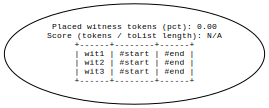

In [17]:
a_n(dtRoot) # returns counter as integer; root is 1
display(SVG(G.render()))

## Go down three levels

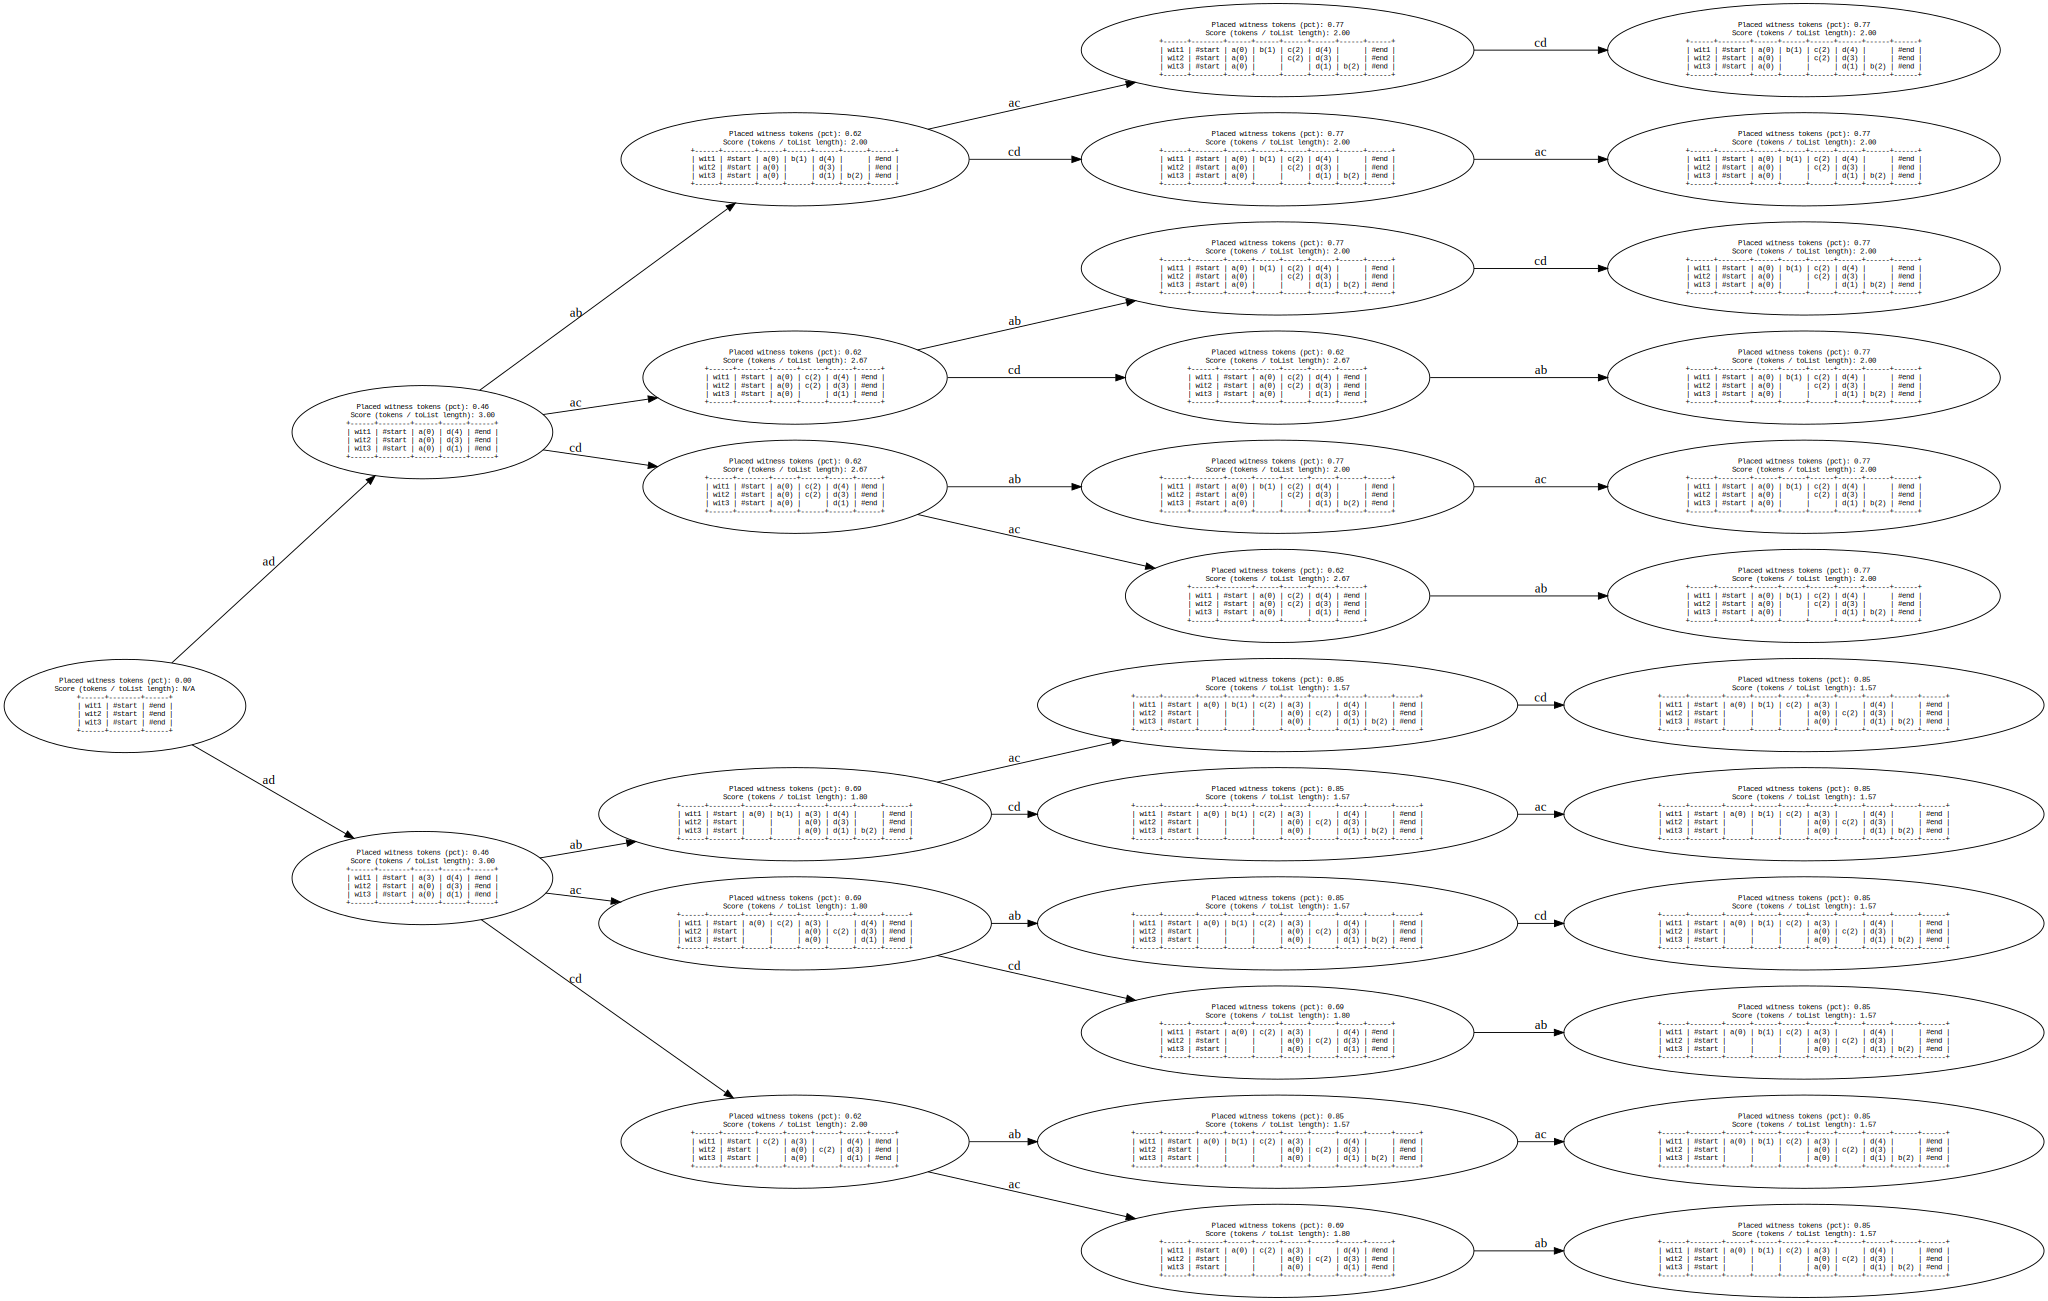

In [18]:
for child in dtRoot.children:
    child_node = a_n(child)
    a_e(str(1), str(child_node), child.skipgram)
    for grandchild in child.children:
        grandchild_node = a_n(grandchild)
        a_e(str(child_node), str(grandchild_node), grandchild.skipgram)
        for greatgrandchild in grandchild.children:
            greatgrandchild_node = a_n(greatgrandchild)
            a_e(str(grandchild_node), str(greatgrandchild_node), greatgrandchild.skipgram)
            for greatgreatgrandchild in greatgrandchild.children:
                greatgreatgrandchild_node = a_n(greatgreatgrandchild)
                a_e(str(greatgrandchild_node), str(greatgreatgrandchild_node), greatgreatgrandchild.skipgram)
display(SVG(G.render()))